In [2]:
#constants (ms, muM, l)
k_l = 1
k_ml = 1
k_r = 0.1 * 1e-3
k_b = 0.1 * 1e-3
#l#????
a_b = 800 * 1e-3
a_r = 80 * 1e-3
a_rp = a_r
d_b = 1000 * 1e-3
d_r = 100 * 1e-3

E_start = 10000
B_start = 2000
R_start = 200

V = 1.4e-15
muM = 6.022e17
number_to_muM = 1 / (muM * V)

alpha_m = [0, 0.1, 0.5, 0.75, 1]
alpha_m_O = [0, 0, 0.1, 0.5, 1]

In [3]:
states = {}
reactions = []

In [4]:
def add_reaction(from_, to_, k, d = 0):
    reactions.append([from_, to_, k])
    if d is not 0:
        reactions.append([to_, from_, d])

In [5]:
max_methylation = 4

R = "R"
B = "B"
l = "l"

alphas = {"U": alpha_m, "O": alpha_m_O}

for m in range(max_methylation):
    for state in ["U", "O"]:
        E = "E" + str(m) + state
        E_R = E + "_" + R
        E_m = "E" + str(m+1) + state
        E_m_B = E_m + "_" + B
        
        add_reaction([E, R], [E_R], a_r, d_r)#TODO a_r could depend on whether active or insactive
        
        add_reaction([E_R], [E_m, R], k_r)
        add_reaction([E_m, B], [E_m_B], a_b * alphas[state][m+1], d_b)
        add_reaction([E_m_B], [E, B], k_b)
    
    EU = "E" + str(m) + "U"
    EO = "E" + str(m) + "O"
    
    EU_m = "E" + str(m+1) + "U"
    EO_m = "E" + str(m+1) + "O"
    
    EU_R = EU + "_" + R
    EO_R = EO + "_" + R
    
    EU_B = EU_m + "_" + B
    EO_B = EO_m + "_" + B
    
    add_reaction([EU, l], [EO], k_l, k_ml)
    add_reaction([EU_R, l], [EO_R], k_l, k_ml)
    add_reaction([EU_B, l], [EO_B], k_l, k_ml)

add_reaction(["E" + str(max_methylation) + "U", l], ["E" + str(max_methylation) + "O"], k_l, k_ml)

In [6]:
reactions

[[['E0U', 'R'], ['E0U_R'], 0.08],
 [['E0U_R'], ['E0U', 'R'], 0.1],
 [['E0U_R'], ['E1U', 'R'], 0.0001],
 [['E1U', 'B'], ['E1U_B'], 0.08000000000000002],
 [['E1U_B'], ['E1U', 'B'], 1.0],
 [['E1U_B'], ['E0U', 'B'], 0.0001],
 [['E0O', 'R'], ['E0O_R'], 0.08],
 [['E0O_R'], ['E0O', 'R'], 0.1],
 [['E0O_R'], ['E1O', 'R'], 0.0001],
 [['E1O', 'B'], ['E1O_B'], 0.0],
 [['E1O_B'], ['E1O', 'B'], 1.0],
 [['E1O_B'], ['E0O', 'B'], 0.0001],
 [['E0U', 'l'], ['E0O'], 1],
 [['E0O'], ['E0U', 'l'], 1],
 [['E0U_R', 'l'], ['E0O_R'], 1],
 [['E0O_R'], ['E0U_R', 'l'], 1],
 [['E1U_B', 'l'], ['E1O_B'], 1],
 [['E1O_B'], ['E1U_B', 'l'], 1],
 [['E1U', 'R'], ['E1U_R'], 0.08],
 [['E1U_R'], ['E1U', 'R'], 0.1],
 [['E1U_R'], ['E2U', 'R'], 0.0001],
 [['E2U', 'B'], ['E2U_B'], 0.4],
 [['E2U_B'], ['E2U', 'B'], 1.0],
 [['E2U_B'], ['E1U', 'B'], 0.0001],
 [['E1O', 'R'], ['E1O_R'], 0.08],
 [['E1O_R'], ['E1O', 'R'], 0.1],
 [['E1O_R'], ['E2O', 'R'], 0.0001],
 [['E2O', 'B'], ['E2O_B'], 0.08000000000000002],
 [['E2O_B'], ['E2O', 'B'], 

In [7]:
states = {}

for [f, t, _] in reactions:
    for state in f:
        if state not in states:
            states[state] = 0
    for state in t:
        if state not in states:
            states[state] = 0

null_states = states.copy()

In [8]:
states["E0U"] = E_start * number_to_muM
states["R"] = R_start * number_to_muM
states["B"] = B_start * number_to_muM

In [9]:
def get_activity():
    activity = 0
    for m in range(max_methylation):
        activity += states["E" + str(m) + "O"] * alpha_m_O[m]
        activity += states["E" + str(m) + "U"] * alpha_m[m]
    return activity

In [10]:
get_activity()

0.0

In [11]:
from functools import reduce

def step(dt, states):
    state_delta = null_states.copy()
    
    for f, t, r in reactions:
        prod = reduce(lambda x,y: x*y, map(lambda x: states[x], f))
        for f_ in f:
            state_delta[f_] -= prod * r * dt
        for t_ in t:
            state_delta[t_] += prod * r * dt
    
    for (k, v) in state_delta.items():
        states[k] += v

In [260]:
states

{'E0U': 4.641755691582423,
 'R': 0.023400191351116158,
 'E0U_R': 0.08680754388579828,
 'E1U': 1.0054832023119507,
 'B': 2.1584401140690854,
 'E1U_B': 0.11573837001607742,
 'E0O': 4.641752800555678,
 'E0O_R': 0.08680754130875608,
 'E1O': 1.0633062362995882,
 'E1O_B': 0.05786629168231128,
 'l': 1.0,
 'E1U_R': 0.019318911189092125,
 'E2U': 0.03603951903354215,
 'E2U_B': 0.02326730836402873,
 'E1O_R': 0.01937045426073862,
 'E2O': 0.04387894416713116,
 'E2O_B': 0.015421286043261453,
 'E2U_R': 0.0007438016261562347,
 'E3U': 0.0006628906494516853,
 'E3U_B': 0.0007843250682183495,
 'E2O_R': 0.0007507896380854104,
 'E3O': 0.0007369110784294934,
 'E3O_B': 0.0007102427081372899,
 'E3U_R': 1.3056171383715206e-05,
 'E4U': 7.5808630816770715e-06,
 'E4U_B': 1.3088963476274507e-05,
 'E3O_R': 1.3122152706559733e-05,
 'E4O': 7.5808651755330574e-06,
 'E4O_B': 1.3088964681424402e-05}

In [13]:
A = []

In [20]:
for _ in range(10000000):
    states["l"] = 1
    step(0.1, states)
    A.append(get_activity())

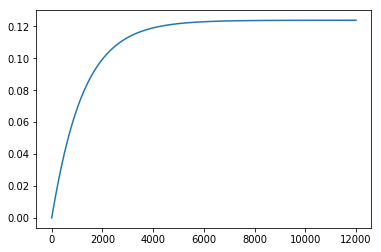

In [21]:
from matplotlib import pyplot as plt
plt.plot(A[::1000]);

In [22]:
steady_state2 = states.copy()
#steady_state = states.copy()
#states = steady_state2.copy()

In [23]:
import csv

w = csv.writer(open("steady_state_new.csv", "w"))
for key, val in steady_state2.items():
    w.writerow([key, val])

In [255]:
cpp_template = """{1}

{0} get_derivs({0} conc)
{{
\t{0} derivs = zeroVector;
\t
{2}
\t
\tderivs[0] = 1;//time
\t
{3}
\t
\treturn derivs;
}}"""

In [256]:
rate_to_text = {}
#TODO

def get_ids_for_states(reactions):
    name_to_id = {}
    names = []
    
    #0 is time
    curr_id = 0
    
    for [f, t, _] in reactions:
        for state in f:
            if state not in name_to_id:
                name_to_id[state] = curr_id
                names.append(state)
                curr_id += 1
        for state in t:
            if state not in name_to_id:
                name_to_id[state] = curr_id
                names.append(state)
                curr_id += 1
    
    return name_to_id, names

def generate_enum(name_to_id):
    inner_str = ",\n\t".join(["%s = %i" % (name, id+1) for (name, id) in name_to_id.items()])
    return "enum Variables {\n\t%s\n};" % inner_str

def make_rate_constants():
    #TODO
    return ""

def get_concentration_string(name):
    return "conc[%s]" % name

def get_predefined_string(f):
    return "__".join(f)

def get_var_string(f, predefined_values):
    if tuple(f) in predefined_values:
        return get_predefined_string(f)
    else:
        return " * ".join(map(get_concentration_string, f))

def get_one_change_with_rate_string(single, predefined_values):
    return get_var_string(single[0], predefined_values) + " * " + single[1]

def get_equation_string(derivative, predefined_values):
    text_fn = lambda x: get_one_change_with_rate_string(x, predefined_values)
    
    positive_string = " + ".join(map(text_fn, derivative["positive"]))
    negative_string = "".join([" - " + text_fn(x) for x in derivative["negative"]])
    return positive_string + negative_string

def get_line_string(name, equation):
    return "\tderivs[%s] = %s;" % (name, equation)

def generate_predefinitions(predefined_values):
    template = "\tconst double %s = %s;"
    return "\n".join(map(lambda f: template % (get_predefined_string(f), " * ".join(map(get_concentration_string, f))), predefined_values))
        

def generate_equations(reactions, name_to_id, names, predefined_values):
    derivatives = [{"positive": [], "negative":[]} for _ in names]
    
    for f, t, r in reactions:            
        for f_ in f:
            derivatives[name_to_id[f_]]["negative"].append((f, str(r)))#rates arent stored as strings :(
        for t_ in t:
            derivatives[name_to_id[t_]]["positive"].append((f, str(r)))#rates arent stored as strings :(
    
    derivative_lines = [get_line_string(names[id], get_equation_string(deriv, predefined_values)) for id, deriv in enumerate(derivatives)]
    
    return "\n".join(derivative_lines)

def generate_Cpp_code(reactions):
    name_to_id, names = get_ids_for_states(reactions)
    
    predefined_values = set()
    
    for f, t, r in reactions:
        if len(f) > 1:
            predefined_values.add(tuple(f))
    
    return cpp_template.format ("std::vector<double>",
                           generate_enum(name_to_id),
                           generate_predefinitions(predefined_values),
                           generate_equations(reactions, name_to_id, names, predefined_values))

In [257]:
#tests

print (get_concentration_string("a"))
print (get_predefined_string (["a", "b", "C"]))
print (get_var_string(["a", "b"], {tuple(["a", "b"])}))
print (get_var_string(["a", "b"], {tuple(["a", "c"])}))

print ()

print (get_equation_string({"positive": [], "negative": []}, {}))
print (get_equation_string({"positive": [(["a", "b", "c"], "k")], "negative": []}, {}))
print (get_equation_string({"positive": [(["a", "b", "c"], "k"), (["a"], "k2")], "negative": [(["f", "g"], "k3"), (["d"], "k2")]}, {tuple(["a", "b", "c"])}))

print ()

print (get_predefinitions({tuple(["a", "b", "c"]), tuple(["a", "aaa"])}))

print (get_predefinitions({}))

conc[a]
a__b__C
a__b
conc[a] * conc[b]


conc[a] * conc[b] * conc[c] * k
a__b__c * k + conc[a] * k2 - conc[f] * conc[g] * k3 - conc[d] * k2

const double a__aaa = conc[a] * conc[aaa]
const double a__b__c = conc[a] * conc[b] * conc[c]



In [258]:
name_to_id, names = get_ids_for_states(reactions)

predefined_values = set()

for f, t, r in reactions:
    if len(f) > 1:
        predefined_values.add(tuple(f))

print(generate_equations(reactions, name_to_id, names, predefined_values))

	derivs[E0U] = conc[E0U_R] * 0.1 + conc[E1U_B] * 0.0001 + conc[E0O] * 1 - E0U__R * 0.08 - E0U__l * 1;
	derivs[R] = conc[E0U_R] * 0.1 + conc[E0U_R] * 0.0001 + conc[E0O_R] * 0.1 + conc[E0O_R] * 0.0001 + conc[E1U_R] * 0.1 + conc[E1U_R] * 0.0001 + conc[E1O_R] * 0.1 + conc[E1O_R] * 0.0001 + conc[E2U_R] * 0.1 + conc[E2U_R] * 0.0001 + conc[E2O_R] * 0.1 + conc[E2O_R] * 0.0001 + conc[E3U_R] * 0.1 + conc[E3U_R] * 0.0001 + conc[E3O_R] * 0.1 + conc[E3O_R] * 0.0001 - E0U__R * 0.08 - E0O__R * 0.08 - E1U__R * 0.08 - E1O__R * 0.08 - E2U__R * 0.08 - E2O__R * 0.08 - E3U__R * 0.08 - E3O__R * 0.08;
	derivs[E0U_R] = E0U__R * 0.08 + conc[E0O_R] * 1 - conc[E0U_R] * 0.1 - conc[E0U_R] * 0.0001 - E0U_R__l * 1;
	derivs[E1U] = conc[E0U_R] * 0.0001 + conc[E1U_B] * 1.0 + conc[E1U_R] * 0.1 + conc[E2U_B] * 0.0001 + conc[E1O] * 1 - E1U__B * 0.08000000000000002 - E1U__R * 0.08 - E1U__l * 1;
	derivs[B] = conc[E1U_B] * 1.0 + conc[E1U_B] * 0.0001 + conc[E1O_B] * 1.0 + conc[E1O_B] * 0.0001 + conc[E2U_B] * 1.0 + conc[E2U_B]

In [259]:
print(generate_Cpp_code(reactions))

enum Variables {
	E0U = 1,
	R = 2,
	E0U_R = 3,
	E1U = 4,
	B = 5,
	E1U_B = 6,
	E0O = 7,
	E0O_R = 8,
	E1O = 9,
	E1O_B = 10,
	l = 11,
	E1U_R = 12,
	E2U = 13,
	E2U_B = 14,
	E1O_R = 15,
	E2O = 16,
	E2O_B = 17,
	E2U_R = 18,
	E3U = 19,
	E3U_B = 20,
	E2O_R = 21,
	E3O = 22,
	E3O_B = 23,
	E3U_R = 24,
	E4U = 25,
	E4U_B = 26,
	E3O_R = 27,
	E4O = 28,
	E4O_B = 29
};

std::vector<double> get_derivs(std::vector<double> conc)
{
	std::vector<double> derivs = zeroVector;
	
	const double E2O__R = conc[E2O] * conc[R];
	const double E1U__R = conc[E1U] * conc[R];
	const double E2U__B = conc[E2U] * conc[B];
	const double E2U_B__l = conc[E2U_B] * conc[l];
	const double E1U__l = conc[E1U] * conc[l];
	const double E4U__B = conc[E4U] * conc[B];
	const double E2U__R = conc[E2U] * conc[R];
	const double E0U__l = conc[E0U] * conc[l];
	const double E3U__R = conc[E3U] * conc[R];
	const double E1U_B__l = conc[E1U_B] * conc[l];
	const double E3U__l = conc[E3U] * conc[l];
	const double E1O__R = conc[E1O] * conc[R];
	cons